In [1]:
adir = '/data/visitor/hc3737/bm02/analysis/'
ddir = '/data/visitor/hc3737/bm02/dataspec/'

%cd {adir}

/mntdirect/_data_visitor/hc3737/bm02/analysis


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyFAI as pf
import h5py
import os
import xrayutilities as xu
import hc3737fun as f
from silx.io import specfile

from ipywidgets import interact
from imp import reload

/users/zatterin/Envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Sample: e18026b - PTO/SRO SL

In [3]:
sample = 'e17062_02'

The images and the specfile parameters are all stored in `analysis/e18026b_02/e18026b_02.h5`; they have been written to this `h5` file by the `append_imgs_h5` script. All that is left is to convert the relevant scans to q space while correcting for the displacements resulting from temperature. Below is a list of

In [4]:
scan_no = [11,19,26,33,40,47,54,61,68,75,82,89,96,104] 
tthsub_no = [9,17,24,31,38,45,52,59,66,73,80,87,94,101]
tthsub = [46.6588,46.6161,46.5662,46.5202,46.5397,46.5883,46.6213,46.6336,46.6458,46.6698,46.6795,46.6909,46.7132,46.7241]

In [5]:
sf = specfile.SpecFile('{0}{1}.spec'.format(ddir, sample))

In [6]:
sf[23].motor_position_by_name('euroc')

400.0

In [7]:
chisub = []
thsub = []
for scan_no in tthsub_no: 
    chisub.append(sf[scan_no].motor_position_by_name('CHI'))
    thsub.append(sf[scan_no].motor_position_by_name('THETA'))

In [8]:
for scan_no, th, tth, ch in zip(tthsub_no, thsub, tthsub, chisub):
    ch = np.round(ch, decimals=3)
    th = np.round(th, decimals=3)
    print('{0}....dchi = {1:.3f}....dth = {2:.3f}'.format(scan_no, ch-90, th-tth/2))

9....dchi = 0.382....dth = 0.022
17....dchi = 0.402....dth = 0.046
24....dchi = 0.453....dth = 0.085
31....dchi = 0.293....dth = 0.247
38....dchi = 0.383....dth = 0.296
45....dchi = 0.343....dth = 0.301
52....dchi = 0.443....dth = 0.298
59....dchi = 0.353....dth = 0.302
66....dchi = 0.394....dth = 0.299
73....dchi = 0.333....dth = 0.307
80....dchi = 0.374....dth = 0.305
87....dchi = 0.334....dth = 0.310
94....dchi = 0.444....dth = 0.313
101....dchi = 0.373....dth = 0.313


Convert the dataset to qspace and grid the intensity. Grid also the **Q** values so that 3D coordinate for each intensity value exists.

In [9]:
reload(f)

<module 'hc3737fun' from '/mntdirect/_data_visitor/hc3737/bm02/analysis/hc3737fun.py'>

In [15]:
qx, qy, qz, gint = f.qconvert(sample, 19, 300, imgstack=None, deltas=[0.402,0.046+.55,0,0,0], #th, ch, phi, nu, tth
                              roi=[0, 579, 600, 1153], filtcorrection=True, cenpix=[292,997-20])
# grid q space
nx, ny, nz = gint.shape
qxx, qyy, qzz = np.mgrid[qx.min():qx.max():1j * nx,
                         qy.min():qy.max():1j * ny,
                         qz.min():qz.max():1j * nz]

--> Cen pix: [292, 977]
--> Filt correction: True
>> Images loaded
0.0 1615761.0
(501, 579, 553) (501, 579, 553)


In [16]:
# clip values lowrer than a number, then log it
i = xu.maplog(gint, 10)
# i = i.transpose(0,2,1)

Look at the projections:

<IPython.core.display.Javascript object>


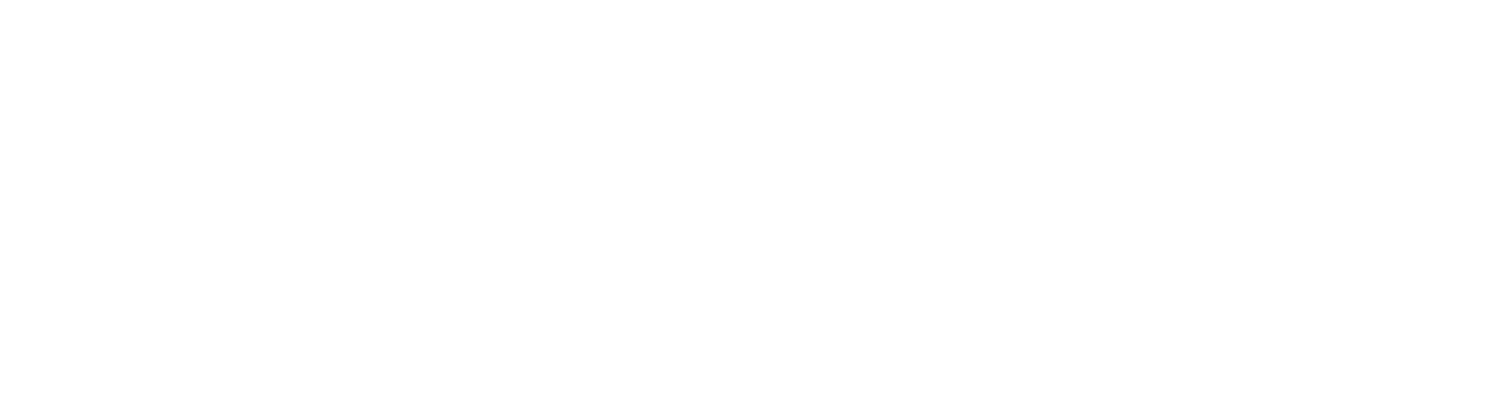

Text(0,0.5,'Qy')

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4),dpi=100)

ax1.pcolormesh(qyy[0,:,:],qzz[0,:,:],i.sum(0))
ax1.axis('image')
ax1.set_xlabel('Qy')
ax1.set_ylabel('Qz')

ax2.pcolormesh(qxx[:,0,:],qzz[:,0,:],i.sum(1))
ax2.axis('image')

ax2.set_xlabel('Qx')
ax2.set_ylabel('Qz')

ax3.pcolormesh(qxx[:,:,0],qyy[:,:,0],i.sum(2))
ax3.axis('image')
ax3.set_xlabel('Qx')
ax3.set_ylabel('Qy')

In [18]:
# %matplotlib inline
# # along y
# @interact(s=(0,i.shape[0]))
# def plot(s=50):
#     plt.figure(figsize=(8,6),dpi=100)
#     plt.title('Slice @ Qy={0:.3f}'.format(qyy[0,s,0]))
#     plt.pcolormesh(qxx[:,0,:],qzz[:,0,:],np.log(gint[:-1,s,:-1]));
#     plt.ylabel('Qz')
#     plt.xlabel('Qx')
#     plt.axvline(0)
#     plt.axis('image')

In [20]:
%matplotlib notebook
# along x
@interact(s=(0,i.shape[0]))
def plot(s=163):
    plt.figure(figsize=(12,12),dpi=100)
    plt.title('Slice @ Qx={0:.3f}'.format(qxx[s,0,0]))
    plt.pcolormesh(qyy[0,:,:],qzz[0,:,:],np.log(gint[s,:-1,:-1]));
    plt.ylabel('Qz')
    plt.xlabel('Qy')
    plt.axvline(-0.01)
    plt.axhline(3.1571,c='r')
    plt.axis('image')

interactive(children=(IntSlider(value=163, description='s', max=300), Output()), _dom_classes=('widget-interac…

### Correct for tilts

array([-0.01040609])

<IPython.core.display.Javascript object>


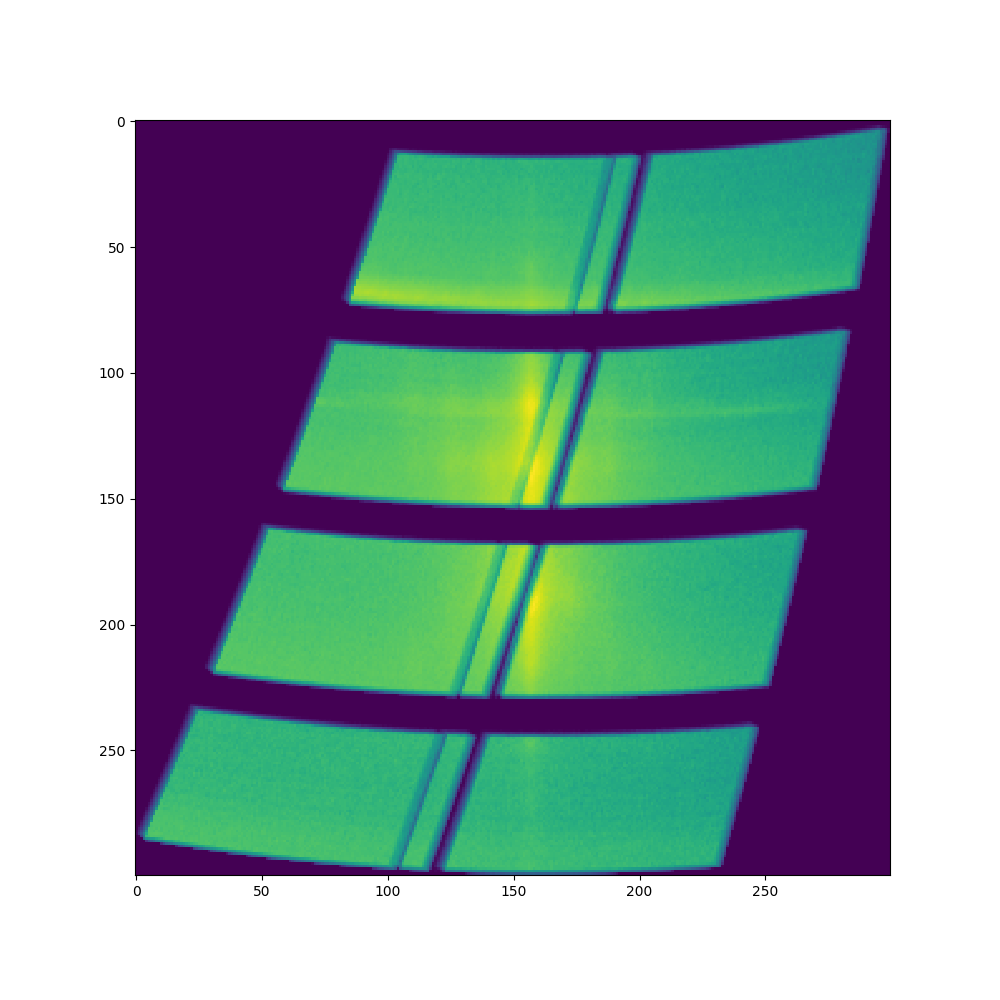

In [139]:
%matplotlib notebook
plt.figure(figsize=(10,10),dpi=100)
plt.imshow(i.sum(1))

In [16]:
zRoi = (180, 210) 
yRoi = (145, 160)
xRoi = (150, 165) 

In [17]:
iroi = np.s_[xRoi[0]:xRoi[1],yRoi[0]:yRoi[1],zRoi[0]:zRoi[1]]
roi, qxr, qyr, qzr = [array[iroi] for array in (gint, qxx, qyy, qzz)]

In [18]:
take = int(100)
# print(take/roi.size*100)
isort = roi.ravel().argsort()[::-1][:take]
roisort = roi.ravel()[isort]  - roi.ravel()[isort].min()
qCOM = [(arr.ravel()[isort]*roisort).sum() / roisort.sum() for arr in (qxr,qyr,qzr)]
print(qCOM)

[-0.000826919493725064, -0.0038357820198803463, 3.190991243233722]


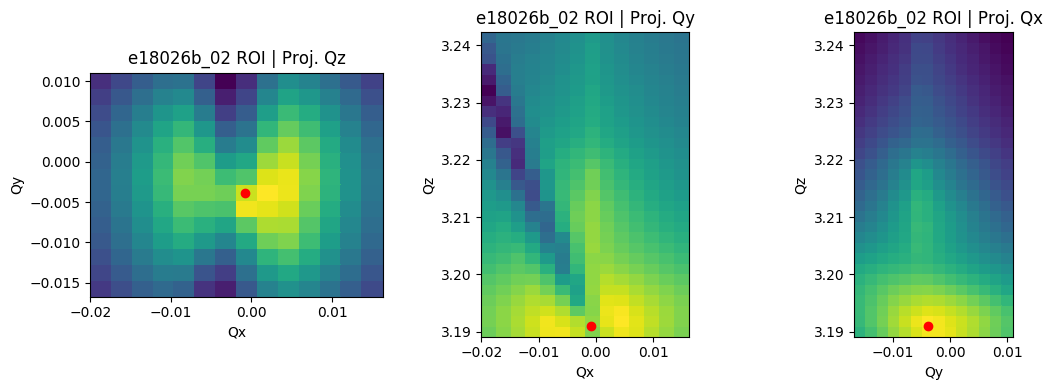

In [19]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(11,4),dpi=100)

ax1.set_title('{0} ROI | Proj. Qz'.format(sample))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],np.log(roi.sum(axis=2)))
ax1.set_ylabel('Qy');ax1.set_xlabel('Qx')
ax1.scatter(qCOM[0],qCOM[1],c='r')
ax1.set_aspect('equal')

ax2.set_title('{0} ROI | Proj. Qy'.format(sample))
ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],np.log(roi.sum(axis=1)))
ax2.set_ylabel('Qz');ax2.set_xlabel('Qx')
ax2.scatter(qCOM[0],qCOM[2],c='r')
ax2.set_aspect('equal')

ax3.set_title('{0} ROI | Proj. Qx'.format(sample))
ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],np.log(roi.sum(axis=0)))
ax3.set_ylabel('Qz');ax3.set_xlabel('Qy')
ax3.scatter(qCOM[1],qCOM[2],c='r')
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

In [20]:
qxp, qyp, qzp = qCOM
Q = np.sqrt(qxp**2+qyp**2+qzp**2)
_001 = (2*np.pi)/Q
ang = np.rad2deg(np.arcsin((np.sqrt(qxp**2+qyp**2)/Q)))

print('|Q|={0}'.format(np.round(2*_001,decimals=4))) # length of the q vector
print('Qz={0}'.format(np.round((2*2*np.pi/qzp),decimals=4))) # z component of q vec
print('ang={0}'.format(np.round(ang,decimals=4))) # tilt

# if off specular, e.g. 103
c = 2*(2*np.pi)/qzp
a = (2*np.pi)/qxp
print('c={0}; a={1}'.format(np.round(c,decimals=4),np.round(a,decimals=3)))

|Q|=3.9381
Qz=3.9381
ang=0.0705
c=3.9381; a=-7598.304


In [21]:
# tilt correction
dtheta = np.rad2deg(np.arctan(qxp/qzp))
drhy = np.rad2deg(np.arctan(qyp/qzp))
dphi = 90 - np.rad2deg(np.arctan(qxp/qyp))
print('eta_off: {0}\nrhy_off: {1}'.format(np.round(dtheta, decimals=4), np.round(drhy, decimals=4)))
print('phi_off: {0}'.format(np.round(dphi, decimals=4)))

eta_off: -0.0148
rhy_off: -0.0689
phi_off: 77.8343


### Correct for tilts #2
Only using the max intensity of the 3D I array

In [123]:
qxp = qxx[i==i.max()][0]
qyp = qyy[i==i.max()][0]
qzp = qzz[i==i.max()][0]

In [124]:
Q = np.sqrt(qxp**2+qyp**2+qzp**2)
_001 = (2*np.pi)/Q
ang = np.rad2deg(np.arcsin((np.sqrt(qxp**2+qyp**2)/Q)))

print('|Q|={0}'.format(np.round(2*_001,decimals=4))) # length of the q vector
print('Qz={0}'.format(np.round((2*2*np.pi/qzp),decimals=4))) # z component of q vec
print('ang={0}'.format(np.round(ang,decimals=4))) # tilt

# if off specular, e.g. 103
c = 2*(2*np.pi)/qzp
a = (2*np.pi)/qxp
print('c={0}; a={1}'.format(np.round(c,decimals=4),np.round(a,decimals=3)))

|Q|=3.9433
Qz=3.9433
ang=0.0399
c=3.9433; a=-2832.381


In [125]:
# tilt correction
dtheta = np.rad2deg(np.arctan(qxp/qzp))
drhy = np.rad2deg(np.arctan(qyp/qzp))
dphi = 90 - np.rad2deg(np.arctan(qxp/qyp))
print('eta_off: {0}\nrhy_off: {1}'.format(np.round(dtheta, decimals=4), np.round(drhy, decimals=4)))
print('phi_off: {0}'.format(np.round(dphi, decimals=4)))

eta_off: -0.0399
rhy_off: 0.0011
phi_off: 178.3702


## ROI for further integration

In [127]:
22/68

0.3235294117647059